# Imports

In [1]:
# Logging and warnings
import logging

# File R/W
import os

# Additional Inbuilt Utilities
import itertools
import functools

# Regex
import re

# Array
import numpy as np

# Table
import pandas as pd

# Advanced Computations
import scipy as sc

# Statistics
import statsmodels.api as sm

# Neurophysiological Data Analysis
import mne
import mne_nirs # esp. for fNIRS

# Neuroimaging Statistical Tools
import nilearn
import nilearn.plotting

# Plotting
import matplotlib.pyplot as plt

# Vistual Display
from pyvirtualdisplay import Display

In [2]:
# Autoreload Custom Modules
%load_ext autoreload
%autoreload 1

# Custom Class
%aimport nirs
NIRS = nirs.NIRS

# Custom Settings
%aimport constants

# Custom Functions
%aimport utils

# Modified MBLL
%aimport mbll

## Config

In [3]:
# Set logging level for custom modules
logging.getLogger().setLevel(logging.INFO)

In [4]:
# Set logging level for MNE
mne.set_log_level('WARNING')

In [5]:
# Set plotting backend for MNE
mne.viz.set_browser_backend('matplotlib') # qt, matplotlib
mne.viz.set_3d_backend('notebook') # pyvistaqt, notebook

# MAIN

In [6]:
# Instantiate NIRS() and read data
nirs = NIRS(project='Multi-object Tracking').read(1, 1, 4, augment=True, transform=False, correction_factor='default')

In [7]:
# Pre-process the data using the default pipeline.
# Output is a dictionary of intermediate mne.Raw instances.
# Stages: CW     (raw signal)
#         CWx    (backlight removed raw signal)
#         OD     (optical density)
#         TDDR   (motion artifact removal)
#         AP     (autopick channels)
#         SSR    (short-channel regression)
#         HB     (chromophore/haemoglobin)
#         AP     (pick long channels, after saving short channels)
#         FL     (bandpass filtering)
#         NCE    (negative correlation improvement)
savepoints = nirs.default_pipeline(remove_backlight=True,
                                   tddr=True,
                                   autopick_channels=True,
                                   short_channel_regression=True,
                                   bandpass=True,
                                   negative_correlation_enhancement=False)

In [8]:
nirs.get_epochs(tmin=-(nirs.DUR['wait'] + nirs.DUR['target']),
                tmax=(nirs.DUR['motion'] + nirs.DUR['probe'] + nirs.DUR['feedb']),
                baseline= (-(nirs.DUR['wait'] + nirs.DUR['target']), 0));
# nirs.block_average();

In [9]:
# Drop epochs where response was not correct
nirs.epochs.drop(nirs.mat['id_correct'] != 1);

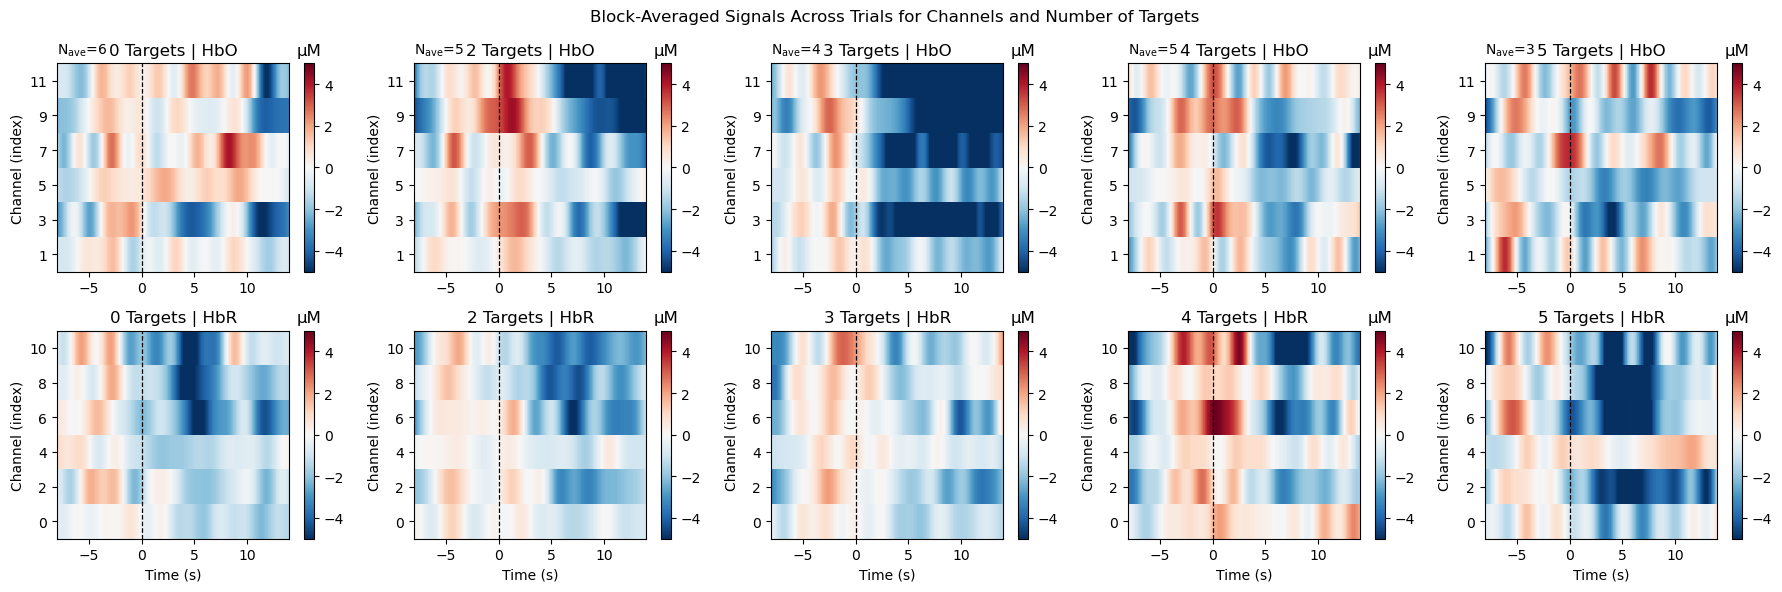

In [10]:
nirs.plot_average_heatmap(clim={'hbo': [-5, 5], 'hbr': [-5, 5]}).tight_layout()

---

`Working Memory Task`

---

`GLM Analysis`

In [11]:
raw_intensity = savepoints['CW']
raw_haemo = nirs.raw.copy().pick('hbo')

In [12]:
design_matrix = mne_nirs.experimental_design.make_first_level_design_matrix(raw_haemo,
                                                                            hrf_model='spm', # 'spm + derivative + dispersion'
                                                                            # drift_model='polynomial', # 'cosine'
                                                                            # drift_order=3,
                                                                            # high_pass=1/2/(nirs.DUR['trial']),
                                                                            stim_dur=nirs.DUR['motion'])

design_matrix['mean_ss_hbo'] = np.mean(nirs.raw_ss.copy().pick('hbo').get_data(), axis=0)
# design_matrix['mean_ss_hbr'] = np.mean(nirs.raw_ss.copy().pick('hbr').get_data(), axis=0)

In [13]:
glm_est = mne_nirs.statistics.run_glm(raw_haemo, design_matrix)

In [14]:
glm_est.to_dataframe()

variable,Condition,df,mse,p_value,se,t,theta,Source,Detector,Chroma,Significant,ch_name
80,0,20.0,3.217489e-13,5.564158e-08,1.407240e-07,-8.388094,-1.180406e-06,44,39,hbo,True,S44_D39 hbo
81,2,20.0,3.217489e-13,2.556091e-06,1.412984e-07,-6.481170,-9.157792e-07,44,39,hbo,True,S44_D39 hbo
82,3,20.0,3.217489e-13,1.236385e-10,1.405152e-07,-12.064624,-1.695264e-06,44,39,hbo,True,S44_D39 hbo
83,4,20.0,3.217489e-13,4.376149e-06,1.376026e-07,-6.231113,-8.574175e-07,44,39,hbo,True,S44_D39 hbo
84,5,20.0,3.217489e-13,4.066185e-02,1.478183e-07,-2.188593,-3.235141e-07,44,39,hbo,True,S44_D39 hbo
...,...,...,...,...,...,...,...,...,...,...,...,...
55,drift_6,20.0,1.005401e-12,4.112567e-13,6.727621e-06,-16.497143,-1.109865e-04,43,39,hbo,True,S43_D39 hbo
56,drift_7,20.0,1.005401e-12,1.857883e-13,6.363661e-06,17.211572,1.095286e-04,43,39,hbo,True,S43_D39 hbo
57,drift_8,20.0,1.005401e-12,7.548031e-07,6.266366e-06,-7.063178,-4.426046e-05,43,39,hbo,True,S43_D39 hbo
58,drift_9,20.0,1.005401e-12,2.426216e-22,6.059697e-06,49.188330,2.980664e-04,43,39,hbo,True,S43_D39 hbo


---

`Plotting for GLM Analysis`

---

`Clustering`